# Acker Merrall & Condit

## Scraping Data

In [1]:
#acker merrall and condit! not ackerman! XD
import Scrapers.ackerman_scraper as ack_scraper
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import datetime as dt
from visualizations_helpers import *

In [2]:
# Use this if you have the Raw Data cached
filename = 'Raw Acker Data.csv'
try:
    raw = pd.read_csv(filename,na_filter=False) 
# Scrapes and writes to csv the raw data
except FileNotFoundError:    
    raw = ack_scraper.dataframe_ackerman_auction()
    raw.to_csv(filename, encoding='utf-8', index=False)


In [3]:
print( raw.shape )
raw.head()

(31962, 14)


,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,bn sdc,,1,,,bottle,3968.0,1982,Chateau Angelus
1,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1983,Chateau Angelus
2,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,spc,,1,,,bottle,3968.0,1985,Chateau Angelus
3,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1988,Chateau Angelus
4,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1990,Chateau Angelus


## Basic Data Cleaning

In [4]:
# identify which columsn to look into how to clean for null values
toFix = []
for column, typecol in raw.dtypes.iteritems():
    #if( typecol == "object"):
    #    blanks = raw[ raw[column] == "" ]
    #else:
    blanks = raw[ raw[column].isnull() ]
    if(blanks.size):
        toFix.append(column)
        toFix.append(blanks.shape)
toFix

[]

Auction Date may not be important yet, but for time, may be need to be parsed from the Auction Name?
We'll default blank designation and producers to the wine
If just one is blank, the ProducerAndDesignation column will still have things and that will be the primary anyway

In [5]:
# confirming that's true
only_producer = raw[ raw["Producer"].isnull() & raw["Designation"].notnull() ]
producer_check = only_producer["Designation"] == only_producer["ProducerAndDesignation"]
print(producer_check.all())

only_designation = raw[ raw["Designation"].isnull() & raw["Producer"].notnull() ]
designation_check = only_designation["Producer"] == only_designation["ProducerAndDesignation"]
print(designation_check.all())

True
True


In [6]:
# filling in when both are empty
raw.loc[ raw["ProducerAndDesignation"] == ""] = raw.loc[ raw["ProducerAndDesignation"] == "", ["Wine"] ]

# confirm it's fixed
raw[ raw["ProducerAndDesignation"] == ""].isnull()

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine


## Aggregation of Data for Individual Bottles

In [7]:
# need to group by lot number, append most rows, but the price seems to be static so don't sum that
# for now,  filtering away mixed lots by saying anything that has shared lot numbers shoudl be removed

df = raw.drop_duplicates(subset=['Auction.ID', 'LotNo'], keep=False)
df = df.reset_index()
print( df.shape )
df.head()

(12840, 15)


,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,356,,1202.0,"187 Oct 12, 2018 (NY)",12.0,12 bottles,2vlbsl 3lwrl,,77,chateau de la tour,chateau de la tour,bottle,2232.0,2001,Les Forts de Latour
1,486,,1202.0,"187 Oct 12, 2018 (NY)",1.0,1 bottle,nl,,95,A. Rousseau,A. Rousseau,bottle,4960.0,1990,Chambertin
2,493,,1202.0,"187 Oct 12, 2018 (NY)",1.0,1 bottle,lbsl,Clos St. Jacques,97,A. Rousseau,"Clos St. Jacques, A. Rousseau",bottle,4340.0,1985,Gevrey Chambertin
3,494,,1202.0,"187 Oct 12, 2018 (NY)",2.0,2 bottles,2lbsl,Clos St. Jacques,98,A. Rousseau,"Clos St. Jacques, A. Rousseau",bottle,2232.0,1988,Gevrey Chambertin
4,551,,1202.0,"187 Oct 12, 2018 (NY)",3.0,3 bottles,,,106,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,6200.0,2002,Echezeaux


# Dataframe Enrichments

In [8]:
# convert to dollars
HKDUSD = 0.1277
def toUSD(row):
    if 'HK' in row['Auction.Name']:
       return row['SoldAmount'] * HKDUSD
    else:
       return row['SoldAmount'] 

df['SoldAmountUSD'] = df.apply( toUSD, axis = 1 )
    
# compute unit price by bottle
df['UnitPriceUSD'] = df[ 'SoldAmountUSD' ] / df[ 'BottleQuantity' ]

#Extract Date from Auction.Name column
date_col = 'Date'
date_search_regex = '[a-zA-Z]{3} .* \\d{4}'
df[date_col] = df['Auction.Name'].apply(lambda s: re.search(date_search_regex, s).group())
df[date_col] = pd.to_datetime(df[date_col])

# bottle sizes only for now
bottle_df = df[(df["BottleSummary"].str.contains("bottle") == True) & (df["BottleSummary"].str.contains("half") == False)]
bottle_df.shape

(10467, 18)

In [9]:
#some like Burgundys or champagnes need ProducerAndDesignation WITH Wine
#for Bordeauxs they are often all the same
bottle_grouped = bottle_df.groupby(['Vintage', "Wine", "ProducerAndDesignation"]).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
bottle_grouped = bottle_grouped.reset_index()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)

### Looking at an example: Mouton Rothschild 1982

In [10]:
mouton_grouped = bottle_grouped[ bottle_grouped["ProducerAndDesignation"].str.contains("Mouton") ]
mouton_all = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains( "Mouton") ]
mouton_grouped.head()

,Vintage,Wine,ProducerAndDesignation,min,mean,max,count
2218,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1766.346400,1999.909783,2365.642500,25
795,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,992.000000,1215.591410,1482.000000,23
979,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,806.000000,905.878661,1033.333333,23
1547,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,499.413417,535.796175,568.333333,10
1918,1998,Chateau Mouton Rothschild,Chateau Mouton Rothschild,473.128500,558.360074,633.392000,9


In [11]:
mouton_1982 = mouton_all[ mouton_all['Vintage'] == "1982"]
mouton_1982.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
1853,7131,,1192.0,"185 Jun 20, 2018 (NY)",3.0,3 bottles,1hs 1sdc 1ts 1vhs 3lbsl,,491,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,2976.0,1982,Chateau Mouton Rothschild,2976.000,992.000000,2018-06-20
2412,7997,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,10lbsl 1cuc 1x12 bottle owc 2nc 2spc 2vlbsl 3l...,,1308,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1033.333333,2018-06-20
4400,12135,,1187.0,"183A Apr 21, 2018 (HK)",12.0,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.408,1266.784000,2018-04-21
4446,12188,,1187.0,"183A Apr 21, 2018 (HK)",2.0,2 bottles,1bn 1lbsl 1lgsl 1ts,,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.568,1266.784000,2018-04-21
4620,12508,,1187.0,"183A Apr 21, 2018 (HK)",3.0,3 bottles,1bn 1bsl 1lscl 1scc 1scl 1stl 1ts 1vhs 3nc,,874,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,29760.0,1982,Chateau Mouton Rothschild,3800.352,1266.784000,2018-04-21


In [12]:
mouton_1982.head()
# if looking at mouton 1945, the cheap one "believed to be" that vintage, which may explain low price

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
1853,7131,,1192.0,"185 Jun 20, 2018 (NY)",3.0,3 bottles,1hs 1sdc 1ts 1vhs 3lbsl,,491,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,2976.0,1982,Chateau Mouton Rothschild,2976.000,992.000000,2018-06-20
2412,7997,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,10lbsl 1cuc 1x12 bottle owc 2nc 2spc 2vlbsl 3l...,,1308,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1033.333333,2018-06-20
4400,12135,,1187.0,"183A Apr 21, 2018 (HK)",12.0,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.408,1266.784000,2018-04-21
4446,12188,,1187.0,"183A Apr 21, 2018 (HK)",2.0,2 bottles,1bn 1lbsl 1lgsl 1ts,,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.568,1266.784000,2018-04-21
4620,12508,,1187.0,"183A Apr 21, 2018 (HK)",3.0,3 bottles,1bn 1bsl 1lscl 1scc 1scl 1stl 1ts 1vhs 3nc,,874,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,29760.0,1982,Chateau Mouton Rothschild,3800.352,1266.784000,2018-04-21


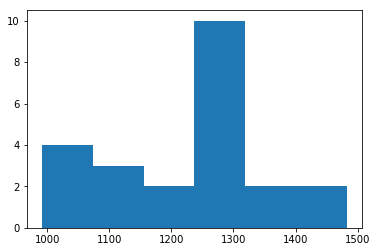

In [13]:
plt.hist( mouton_1982[ 'UnitPriceUSD'], 6 )
plt.show()

### Let's Try Your Own!

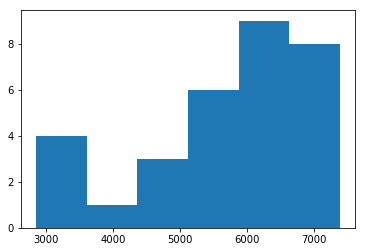

In [14]:
Vintage = "1999"
Producer = "Domaine de la Romanee Conti"
Wine = "La Tache"
producer_only = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains(Producer) ]
producer_wine = producer_only[ producer_only["Wine"].str.contains(Wine) ]

producer_wine_vintage = producer_wine[ producer_wine['Vintage'] == Vintage ]

plt.hist( producer_wine_vintage['UnitPriceUSD'], 6 )
plt.show()

In [15]:
producer_wine_vintage.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
580,3337,,1197.0,"185A Sep 22, 2018 (HK)",6.0,6 bottles,1x6 bottle banded owc,,317,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,297600.0,1999,La Tache,38003.520,6333.920000,2018-09-22
2219,7762,,1192.0,"185 Jun 20, 2018 (NY)",1.0,1 bottle,,,1069,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,5952.0,1999,La Tache,5952.000,5952.000000,2018-06-20
2462,8073,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,1x12 bottle owc 3 bottles different importer,,1372,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,74400.0,1999,La Tache,74400.000,6200.000000,2018-06-20
2727,8468,,1190.0,"184A Jun 9, 2018 (HK)",3.0,3 bottles,,,295,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,138880.0,1999,La Tache,17734.976,5911.658667,2018-06-09
2799,8575,,1190.0,"184A Jun 9, 2018 (HK)",3.0,3 bottles,1vlbsl,,377,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,158720.0,1999,La Tache,20268.544,6756.181333,2018-06-09


## PnL Opportunity

In [16]:
bottle_profit = bottle_grouped[ bottle_grouped["max"] / 1.25 > bottle_grouped["min"] ]
bottle_profit = bottle_profit.reset_index()
bottle_profit['diff'] = bottle_profit['max'] / 1.25 - bottle_profit['min']
bottle_profit = bottle_profit[ bottle_profit["count"] > 10 ]
bottle_profit = bottle_profit.sort_values('diff', ascending = False)
print(bottle_profit.shape)
bottle_profit.head()

(72, 9)


,index,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,diff
4,2120,1999,Romanee Conti,Domaine de la Romanee Conti,10028.706667,18481.627333,23224.373333,24,8550.792
2,2081,1999,La Tache,Domaine de la Romanee Conti,2841.666667,5658.579462,7389.573333,31,3069.992
41,2007,1999,Chambertin,A. Rousseau,899.000000,2914.087885,4960.000000,13,3069.000
42,1185,1990,Chambertin,A. Rousseau,3224.000000,4757.275897,7750.000000,13,2976.000
62,2620,2002,Romanee Conti,Domaine de la Romanee Conti,12616.760000,15934.525697,19001.760000,11,2584.648


# Price momentum over time
For each unique bottle type - [Vintage, Wine, ProducerAndDesignation], use the historical price time series to compute the Annual Percent Change. Fit a linear regression through the price points as a function of ordinal date, then normalize to get the annual percent change. Interpret the Annual Percent Change as the price drift over time.
Also plot the price time series

In [17]:
# Use these filters to scope the bottles
Vintage = ''
Producer = 'Mouton'
Wine = ''
count_threshold = 10

In [18]:
bottle_grouped_percent_change, high_count_bottles = enrich_bottle_price_percent_change(bottle_df, count_threshold = count_threshold)
#bottle_grouped_percent_change.head()
bottle_grouped_percent_change_in_scope = bottle_grouped_percent_change
bottle_grouped_percent_change_in_scope = bottle_grouped_percent_change_in_scope[ 
                                            bottle_grouped_percent_change_in_scope["ProducerAndDesignation"].str.contains(Producer) &
                                            bottle_grouped_percent_change_in_scope["Wine"].str.contains(Wine) &
                                            bottle_grouped_percent_change_in_scope["Vintage"].str.contains(Vintage)
                                            ]
high_count_bottles_in_scope = high_count_bottles
high_count_bottles_in_scope = high_count_bottles_in_scope[ 
                                            high_count_bottles_in_scope["ProducerAndDesignation"].str.contains(Producer) &
                                            high_count_bottles_in_scope["Wine"].str.contains(Wine) &
                                            high_count_bottles_in_scope["Vintage"].str.contains(Vintage)
                                            ]

In [19]:
bottle_grouped_percent_change_in_scope.head()

,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,Annual Percent Change
3,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1766.346400,1999.909783,2365.642500,25,0.144828
109,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,499.413417,535.796175,568.333333,10,0.083935
7,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,806.000000,905.878661,1033.333333,23,0.035559
5,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,992.000000,1215.591410,1482.000000,23,-0.117320


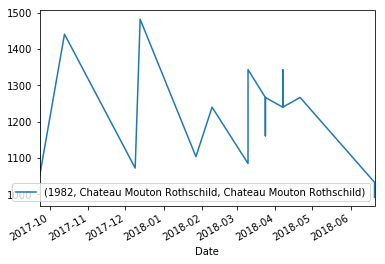

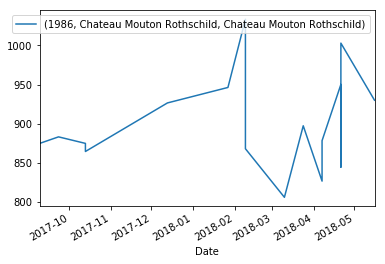

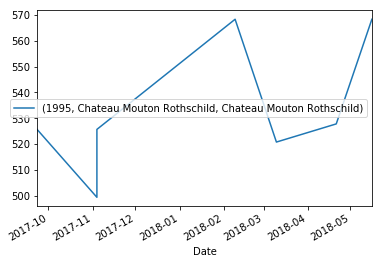

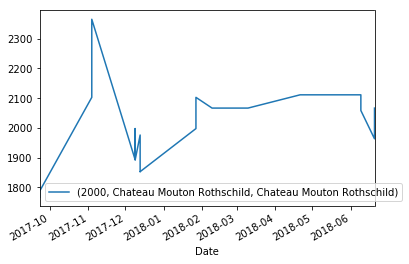

In [20]:
for unique_bottle_key, single_bottle_timeseries in high_count_bottles_in_scope.groupby(unique_bottle_keys):
    plot_price_over_time(single_bottle_timeseries)

# Read Current Auction From Spreadsheet + Scrape the Bid Data
Acker website has a xls sheet of auction items for each live + online auction. We enrich this dataset w/ scraped bid data

In [124]:
# Read in the Spreadsheet
current_auction_filename = 'Online Auction_1Jan19_2674 Lots.xls'
raw_current_auction = pd.read_excel(current_auction_filename,na_filter=False) 
# Manually map to the same schema
# Join against the grouped bottle stats

In [125]:
# Rename columns of Current Auction Spreadsheet and Project away superfluous columns
col_rename_map = {
    'WineName' : 'Wine',
    'Quantity' : 'BottleQuantity',
    'BottleName' : 'Size',
    'Levels' : 'Conditions',
}
raw_current_auction = raw_current_auction.rename( columns = col_rename_map)
raw_current_auction['ProducerAndDesignation'] = raw_current_auction['Wine']
cols_to_retain = ['LotNo', 'Wine', 'ProducerAndDesignation', 'BottleQuantity', 'Size', 'Vintage', 'Conditions', 'Low', 'High']
raw_current_auction = raw_current_auction[cols_to_retain]

In [126]:
# Scrape the bid data
# Use this if you have the Raw Current Auction Data cached
auction_id = 1216
filename = 'Online Auction_1Jan19_2674 Lots Scraped Bid Data.csv'
try:
    current_auction_scraped_bids_raw_df = pd.read_csv(filename,na_filter=False) 
# Scrapes and writes to csv the raw data
except FileNotFoundError:    
    current_auction_scraped_bids_raw_df = ack_scraper.dataframe_current_auction(auction_id)
    current_auction_scraped_bids_raw_df.to_csv(filename, encoding='utf-8', index=False)

In [127]:
# Process the bid data and join against the Current Auction Spreadsheet
current_auction_price_cols_to_retain = ['currentBid','estimateHigh', 'estimateLow', 'lotId', 'lotNo', 'reservePrice', 'winningBidderPaddle', 'winningBidderUserName' ]
current_auction_scraped_bids_df = current_auction_scraped_bids_raw_df[current_auction_price_cols_to_retain]
scraped_bids_col_rename_map = {
    'lotNo' : 'LotNo',
    #'estimateHigh' : 'High', #Wierd mismatches between spreadsheet high/low and auction site high/low
    #'estimateLow' : 'Low',
}
current_auction_scraped_bids_df = current_auction_scraped_bids_df.rename( columns = scraped_bids_col_rename_map)
joined_current_auction = pd.merge(raw_current_auction, current_auction_scraped_bids_df, on=['LotNo'])

In [128]:
# Filter the Current Auction Spreadsheet by Wine in Scope
print('Original DF Size: ', joined_current_auction.shape)
# Only keep single lot items
current_auction_df = joined_current_auction.drop_duplicates(subset=['LotNo'], keep=False)
print('Less multilot DF size:', current_auction_df.shape)

# Only keep Bottles
current_auction_df = current_auction_df[
                                (current_auction_df["Size"].str.contains("bottle") == True) & 
                                (current_auction_df["Size"].str.contains("half") == False)
                                ]
print('Less multilot and nonbottle DF size:', current_auction_df.shape)
current_auction_df = current_auction_df.reset_index(drop = True)

Original DF Size:  (3210, 16)
Less multilot DF size: (2373, 16)
Less multilot and nonbottle DF size: (2146, 16)


## Join the current auction against the historical auction data

In [140]:
# Join the current auction against the historical Summary Stats for Each wine + Vintage
current_auction_df_historical = pd.merge(current_auction_df, bottle_grouped, on=['Wine', 'Vintage', 'ProducerAndDesignation'])

In [142]:
current_auction_df_historical.head()

,LotNo,Wine,ProducerAndDesignation,BottleQuantity,Size,Vintage,Conditions,Low,High,currentBid,estimateHigh,estimateLow,lotId,reservePrice,winningBidderPaddle,winningBidderUserName,min,mean,max,count
0,1,Chateau Pavie,Chateau Pavie,1,bottle,1998,,200,280,180,280,200,289211,180,55950,***,263.913333,266.721111,268.666667,3
1,23,Chateau Lafite Rothschild,Chateau Lafite Rothschild,1,bottle,1982,"vhs, spc, scc, stc",2400,3200,0,3200,2400,289233,2000,0,***,2058.333333,2695.067855,3293.333333,18
2,24,Chateau Lafite Rothschild,Chateau Lafite Rothschild,1,bottle,1982,"htms, nl, nc, ssos",2400,3200,0,3200,2400,289234,2000,0,***,2058.333333,2695.067855,3293.333333,18
3,25,Chateau Lafite Rothschild,Chateau Lafite Rothschild,1,bottle,1982,"htms, nl, nc, ssos",2400,3200,0,3200,2400,289235,2000,0,***,2058.333333,2695.067855,3293.333333,18
4,90,Chateau Lafite Rothschild,Chateau Lafite Rothschild,1,bottle,1982,"ts, lstl, fl, ltl, cuc",2400,3200,0,3200,2400,289300,1900,0,***,2058.333333,2695.067855,3293.333333,18


In [131]:
current_auction_df[current_auction_df['Wine'].str.contains('Mouton')].head()

,LotNo,Wine,ProducerAndDesignation,BottleQuantity,Size,Vintage,Conditions,Low,High,currentBid,estimateHigh,estimateLow,lotId,reservePrice,winningBidderPaddle,winningBidderUserName
69,91,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1,bottle,1982,"ts, vlbsl, lstl, nl",900,1200,700,1200,900,289301,700,62412,itsWezzles
87,113,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1,bottle,2000,,1600,2200,1300,2200,1600,289323,1200,55950,***
310,414,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1,bottle,1988,bsl,350,480,280,480,350,289624,280,56120,thundermountainconsulting
461,585,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1,bottle,1981,"bn, stl, nl",260,350,200,350,260,289795,200,6428,fewchick
462,586,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1,bottle,1984,"ts, stl, lscl",260,350,200,350,260,289796,200,6428,fewchick


In [129]:
#current_auction_df.head()

## Who are the active bidders? What are they buying?

In [135]:
current_auction_bidders = joined_current_auction.groupby(['winningBidderPaddle', 'winningBidderUserName']).agg({"LotNo": pd.Series.nunique})
current_auction_bidders = current_auction_bidders.reset_index()
current_auction_bidders = current_auction_bidders.rename(columns = {'LotNo':'User Bid Count'})
current_auction_bidders = current_auction_bidders.sort_values(by=['User Bid Count'], ascending = False)
current_auction_bidders.head()

,winningBidderPaddle,winningBidderUserName,User Bid Count
0,0,***,1867
66,16598,harper,45
150,56120,thundermountainconsulting,22
138,52176,***,19
173,66532,Soulinair,16


In [137]:
joined_current_auction_bidders = pd.merge(joined_current_auction, current_auction_bidders, on = ['winningBidderPaddle', 'winningBidderUserName'])
# get rid of lots w/ no winning bids
joined_current_auction_bidders = joined_current_auction_bidders[joined_current_auction_bidders['winningBidderPaddle'] != 0]
joined_current_auction_bidders = joined_current_auction_bidders.sort_values(by=['User Bid Count'], ascending = False)
joined_current_auction_bidders.head()

,LotNo,Wine,ProducerAndDesignation,BottleQuantity,Size,Vintage,Conditions,Low,High,currentBid,estimateHigh,estimateLow,lotId,reservePrice,winningBidderPaddle,winningBidderUserName,User Bid Count
2329,2090,Turley Zinfandel,Turley Zinfandel,1,bottle,2004,,,,120,200,150,291300,120,16598,harper,45
2300,1405,Rubicon Estate Red,Rubicon Estate Red,6,bottle,2005,,400,600,350,600,400,290615,350,16598,harper,45
2313,2004,Silver Oak Cabernet Sauvignon,Silver Oak Cabernet Sauvignon,1,bottle,1992,,,,160,260,200,291214,160,16598,harper,45
2312,1997,Corison Cabernet Sauvignon,Corison Cabernet Sauvignon,4,bottle,1999,,130,200,170,200,130,291207,110,16598,harper,45
2311,1996,Corison Cabernet Sauvignon,Corison Cabernet Sauvignon,4,bottle,1996,,120,160,130,160,120,291206,100,16598,harper,45


## ToDos

In [ ]:
#TODO list!
#check auction scraping - all web and in person
#can we scrape more dates? the archives go back longer
#PnL 
#Trend over time - signifcant outliers
#Expected inventory, distributions of profit? strategies? always buy < max?)
#Lot sizes makes difference?
#Ullage level?
#Label condition?
#mixed lots built from single bottles?